# **Phân loại khuôn mặt của top 5 chân sút ghi nhiều bàn nhất thế giới gồm có C.Ronaldo, L.Messi, Pelé, Romario và Ferenc Puskas kèm theo đó là thông tin của các cầu thủ bao gồm họ tên, số áo đấu và số bàn thắng họ ghi được tính đến thời điểm hiện tại (các thông số được lấy từ wikipedia)**

In [32]:
!pip install pytube opencv-python


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Ta sẽ test một tấm hình đã được collect về (giả sử chúng ta lấy bức ảnh của ronaldo)

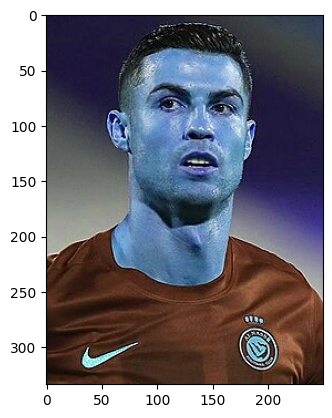

In [34]:
img = cv2.imread('./testscorers/ronaldo1.jpg')
plt.imshow(img)

In [35]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray

array([[33, 34, 34, ..., 69, 65, 65],
       [33, 33, 33, ..., 70, 66, 66],
       [32, 32, 32, ..., 70, 68, 68],
       ...,
       [32, 35, 40, ..., 25, 28, 27],
       [38, 41, 45, ..., 31, 31, 30],
       [37, 40, 44, ..., 33, 32, 31]], dtype=uint8)

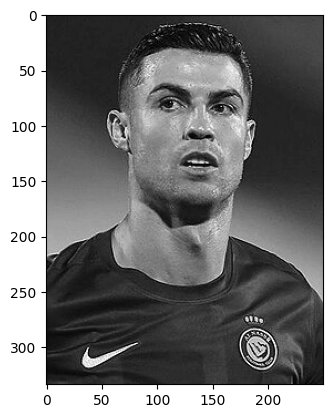

In [36]:
plt.imshow(gray, cmap='gray')

## Data cleaning

Ta sẽ làm việc với những hình ảnh mà ta có thể nhận diện khuôn mặt có đủ 2 mắt (những tấm ảnh không thỏa ví dụ như ta khuôn thể nhìn rõ khuôn mặt hay chỉ 1 nửa mặt ta sẽ thực hiện loại chúng, điều này sẽ giúp cho việc thực hiện mô hình đạt kết quả tốt hơn)

Ta sẽ sử dụng kĩ thuật haar cascade để nhận diện khuôn mặt và đồng thời cả 2 mắt 

In [37]:
face_cascade = cv2.CascadeClassifier('./opencv-4.x/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv-4.x/data/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3,5)
faces

array([[ 70,  28, 137, 137]])

In [38]:
(x,y,w,h) = faces[0]
x,y,w,h

(70, 28, 137, 137)

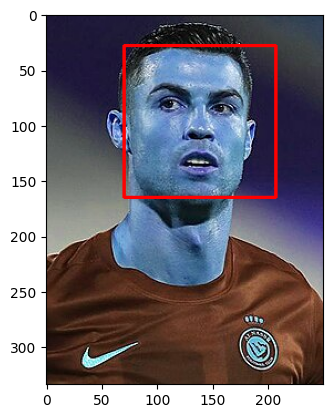

In [39]:
face_img = cv2.rectangle(img,(x,y), (x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

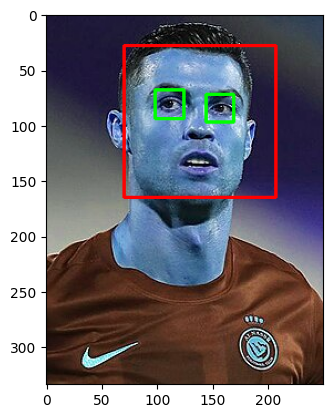

In [40]:
cv2.destroyAllWindows()

for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2)
    roi_gray = gray[y:y+h, x:x+h]
    roi_color = face_img[y:y+h, x:x+h]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(face_img)
plt.show()

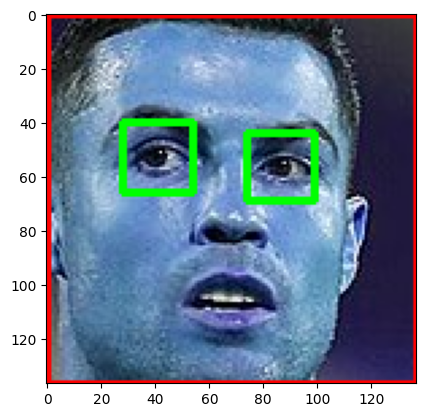

In [41]:
%matplotlib inline
plt.imshow(roi_color)

In [42]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x: x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2: 
            return roi_color
    return None

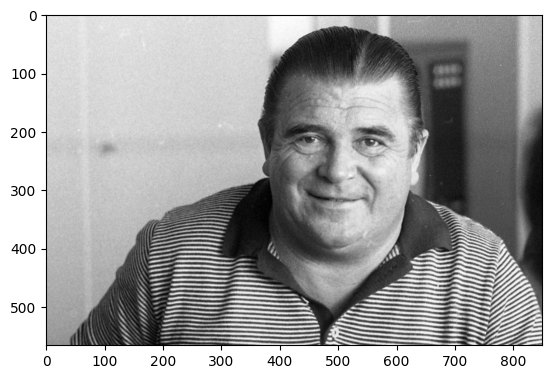

In [43]:
original_image = cv2.imread('./testscorers/puskas_01.jpg')
plt.imshow(original_image)

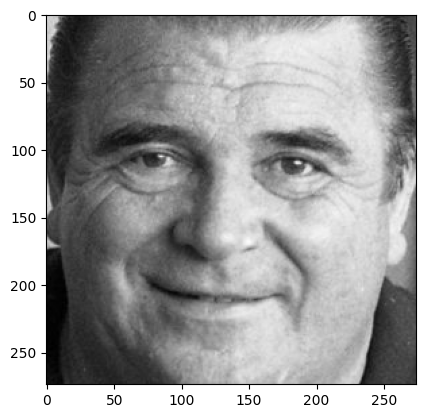

In [44]:
cropped_img = get_cropped_image_if_2_eyes('./testscorers/puskas_01.jpg')
plt.imshow(cropped_img)

In [45]:
import os

path_to_data = './datascorers/'
path_to_cr_data = './datascorers/cropped/'

img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [46]:
img_dirs

['./datascorers/cristiano ronaldo',
 './datascorers/cropped',
 './datascorers/ferenc puskas',
 './datascorers/lionel messi',
 './datascorers/Pele',
 './datascorers/Romario']

In [47]:
import shutil

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)

os.mkdir(path_to_cr_data)

In [49]:
cropped_image_dirs = []
scorers_file_inform_dict = {}

for img_dir in img_dirs:
    count = 1
    scorer_name = img_dir.split('/')[-1]
    print(scorer_name)

    scorers_file_inform_dict[scorer_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + scorer_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print('Generating cropped images in folder: ', cropped_folder)

            cropped_file_name = scorer_name+str(count)+'.png'
            cropped_file_path = cropped_folder+'/'+cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            scorers_file_inform_dict[scorer_name].append(cropped_file_path)
            count+=1

cristiano ronaldo
Generating cropped images in folder:  ./datascorers/cropped/cristiano ronaldo
cropped
ferenc puskas
Generating cropped images in folder:  ./datascorers/cropped/ferenc puskas
lionel messi
Generating cropped images in folder:  ./datascorers/cropped/lionel messi
Pele
Generating cropped images in folder:  ./datascorers/cropped/Pele
Romario
Generating cropped images in folder:  ./datascorers/cropped/Romario


## **Feature engineering:** Ta sử dụng wavelet transform để biến đổi ra các features cho việc train mô hình. Việc sử dụng wavelet transform giúp ta trích xuất tần số cao hay thấp ở những vị trí cụ thể (mắt, môi, sống mũi, lông mày,...) 

In [50]:
!pip install PyWavelets


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import numpy as np
import pywt
import cv2

def w2d(img, mode = 'haar', level = 1):
    imArray = img

    # convert to grayscale
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # convert to float
    imArray = np.float32(imArray)
    imArray /= 255
    # compute coefficient
    coeffs = pywt.wavedec2(imArray, mode, level = level)

    # Process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0]*=0 # Delete LL (Low frequency)

    # Reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H
    

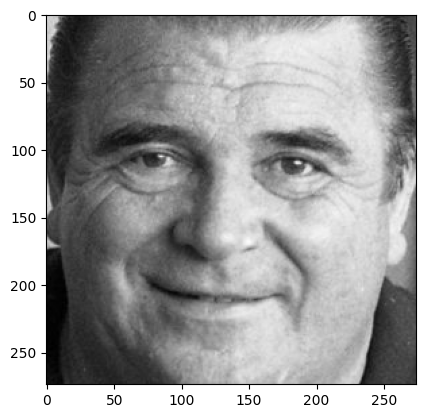

In [52]:
plt.imshow(cropped_img)

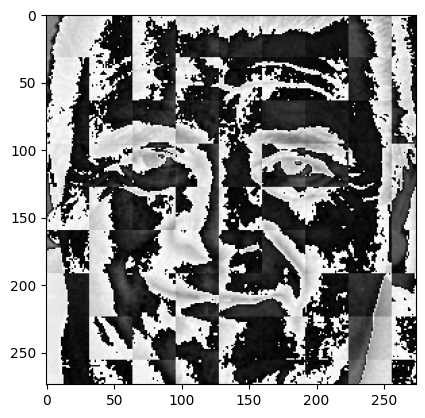

In [53]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Ta có thể thấy biến đổi wavelet có thể cho các đặc trưng ở khuôn mặt như mắt mũi môi,... Bức ảnh này có thể được sử dụng như là đầu vào của mô hình chúng ta sẽ sử dụng.

In [523]:
scorers_file_inform_dict = {}
for img_dir in cropped_image_dirs:
    scorer_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    scorers_file_inform_dict[scorer_name] = file_list
scorers_file_inform_dict

{'cristiano ronaldo': ['./datascorers/cropped/cristiano ronaldo\\12.png',
  './datascorers/cropped/cristiano ronaldo\\13.png',
  './datascorers/cropped/cristiano ronaldo\\14.png',
  './datascorers/cropped/cristiano ronaldo\\15.png',
  './datascorers/cropped/cristiano ronaldo\\16.png',
  './datascorers/cropped/cristiano ronaldo\\17.png',
  './datascorers/cropped/cristiano ronaldo\\18.png',
  './datascorers/cropped/cristiano ronaldo\\19.png',
  './datascorers/cropped/cristiano ronaldo\\20.png',
  './datascorers/cropped/cristiano ronaldo\\21.png',
  './datascorers/cropped/cristiano ronaldo\\22.png',
  './datascorers/cropped/cristiano ronaldo\\23.png',
  './datascorers/cropped/cristiano ronaldo\\24.png',
  './datascorers/cropped/cristiano ronaldo\\25.png',
  './datascorers/cropped/cristiano ronaldo\\26.png',
  './datascorers/cropped/cristiano ronaldo\\27.png',
  './datascorers/cropped/cristiano ronaldo\\28.png',
  './datascorers/cropped/cristiano ronaldo\\29.png',
  './datascorers/cropped/

In [524]:
class_dict = {}
count = 0
for scorer_name in scorers_file_inform_dict.keys():
    class_dict[scorer_name] = count
    count += 1
class_dict

{'cristiano ronaldo': 0,
 'ferenc puskas': 1,
 'lionel messi': 2,
 'Pele': 3,
 'Romario': 4}

In [525]:
X, y = [], []
for scorer_name, training_files in scorers_file_inform_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[scorer_name])

In [520]:
len(X[0])

4096

In [454]:
y[0]

0

In [526]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(262, 4096)

## Training Models

Chúng ta sẽ sử dụng SVM với rbf kernel và tiến hành đánh giá mô hình

In [527]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state = 42)

# Build pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel = 'linear', C = 1))
        ])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8113207547169812

In [528]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.86      0.67      0.75         9
           2       1.00      0.80      0.89        10
           3       0.75      0.92      0.83        13
           4       0.88      0.78      0.82         9

    accuracy                           0.81        53
   macro avg       0.84      0.80      0.81        53
weighted avg       0.83      0.81      0.81        53



Ta sẽ sử dụng GridSearchCV để thử nhiều mô hình với nhiều tham số khác nhau. Mục tiêu ta cần phải tìm là tìm ra được mô hình tốt nhất cộng kèm với tham số tốt nhất của mô hình

In [529]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm':{
        'model': SVC(gamma = 'auto', probability = True),
        'params':{
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },

    'random forest':{
        'model' : RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },

    'logistic_regression':{
        'model': LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params':{
            'logisticregression__C':[1,5,10]
        }
    }
}

In [530]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\Thinkpad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Thinkpad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Thinkpad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Thinkpad\AppData\Local\Progr

,model,best_score,best_params
0,svm,0.751220,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random forest,0.574332,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.722416,{'logisticregression__C': 5}


In [531]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, multi_class='auto',
                                     solver='liblinear'))])}

In [532]:
best_estimators['svm'].score(X_test,y_test)

0.8113207547169812

In [533]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8113207547169812

In [534]:
best_estimators['random forest'].score(X_test,y_test)

0.5849056603773585

In [535]:
best_clf = best_estimators['svm']

In [537]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[10,  1,  0,  0,  1],
       [ 1,  6,  0,  2,  0],
       [ 1,  0,  8,  1,  0],
       [ 1,  0,  0, 12,  0],
       [ 1,  0,  0,  1,  7]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

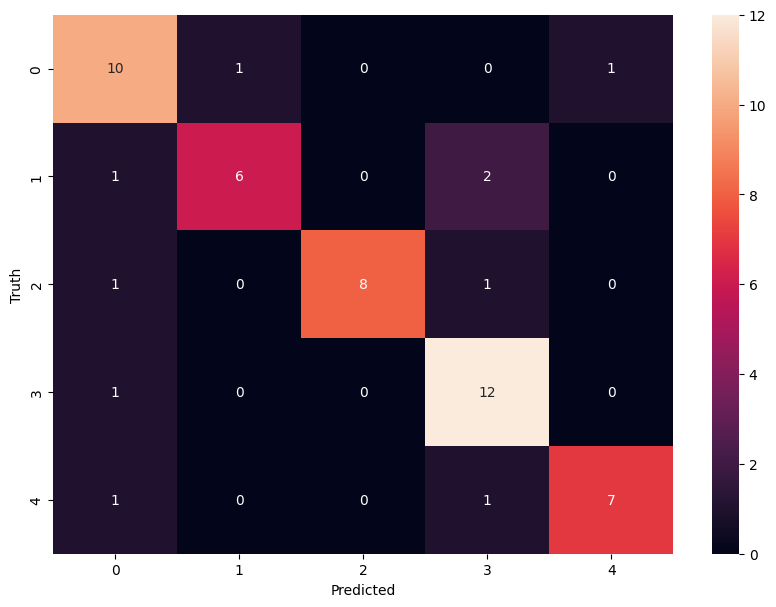

In [538]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [539]:
class_dict

{'cristiano ronaldo': 0,
 'ferenc puskas': 1,
 'lionel messi': 2,
 'Pele': 3,
 'Romario': 4}

In [540]:
!pip install joblib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [541]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [542]:
player_info = {
    'Cristiano Ronaldo': {
        'label': 0,
        'shirt_number': 7,
        'goals': 938
    },
    'Ferenc Puskás': {
        'label': 1,
        'shirt_number': 10,
        'goals': 725
    },
    'Lionel Messi': {
        'label': 2,
        'shirt_number': 10,
        'goals': 866
    },
    'Pelé': {
        'label': 3,
        'shirt_number': 10,
        'goals': 762
    },
    
    'Romário': {
        'label': 4,
        'shirt_number': 11,
        'goals': 756 
    }
}

In [543]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(player_info))